# Group Surveys Feature Determination

## Preparation

### Import

In [41]:
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy import interp
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

## Function Definition

### Min-Max Scaler

In [3]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scaling_df(df, columns):
  
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns]), columns=columns)
    df[df_scaled.columns] = df_scaled

    return df


### Inlcude Marks Classification

In [7]:
def include_mark_classification(df):
  
    df = df[df['theory'] >= 0.5]
    limit1=0.65
    limit2= 0.8
    
    # Define the conditions and corresponding values
    conditions = [
        (df['theory'] >= 0.5) & (df['theory'] < limit1),
        (df['theory'] >= limit1) & (df['theory'] < limit2),
        (df['theory'] >= limit2) & (df['theory'] <= 1)
    ]
    values = [1,2,3]

    # Create the 'mark' column using np.select()
    df['mark'] = np.select(conditions, values, default='np.NaN')

    df = df.dropna(how='any')

    return df

### Select Columns by Index

In [8]:
def select_columns_by_index(df, column_indexes):
  
    cols= column_indexes
    cols.append(len(df.columns)-1)
    selected_columns = df.iloc[:, cols].copy()
    selected_column_names = df.columns[column_indexes].tolist()
    
    return selected_columns, selected_column_names

### Prepare DataFrame for Modeling

In [9]:
def prepare_df_for_modeling(df):

  # Strip off leading and trailing whitespace from non-numeric columns
  df = df.select_dtypes(include=['int', 'float'])
  df = df[df['theory'] >= 0.5]
  df.reset_index(drop=True, inplace=True)
  
  return df

### Return Dataframe by Columns

In [10]:
def return_df_by_columns(df,column_names):

  new_df = df[column_names].copy()
  data = pd.concat([new_df, df['theory']], axis=1)
  data = min_max_scaling_df(data)

  return data

### Get Indexes by Column names

In [12]:
def get_column_indexes(df, columns):
    # Get the indexes of the specified columns
    indexes = [df.columns.get_loc(col) for col in columns]
    return indexes

### Try Hyper-Parameters Random Forest

In [13]:
def evaluate_random_forest_hyper_parameters(df, cv=5):
    # Split the dataframe into features (X) and target (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200, 300],     # Number of trees in the forest
        'max_depth': [None, 5, 10, 20],          # Maximum depth of the trees
        'min_samples_split': [2, 5, 10, 20],     # Minimum number of samples required to split an internal node
        'max_features': ['sqrt'],                # Number of features to consider when looking for the best split
        'min_samples_leaf': [1, 2, 4],            # Minimum number of samples required to be at a leaf node
        'bootstrap': [True, False]                # Whether bootstrap samples are used when building trees
        # Add more hyperparameters and their values here as desired
    }

    # Create a Random Forest classifier
    model = RandomForestClassifier()

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv)
    grid_search.fit(X, y)

    # Get the best hyperparameters and the corresponding mean accuracy
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Create the best model using the best hyperparameters
    best_model = RandomForestClassifier(**best_params)

    # Evaluate the best model using cross-validation
    cv_scores = cross_val_score(best_model, X, y, scoring='accuracy', cv=cv)
    mean_cv_accuracy = cv_scores.mean()

    # Print the best model and evaluation results
    print("Best Model:")
    print(f"Best Hyperparameters: {best_params}")
    print(f"Mean Accuracy: {best_score:.4f}")
    print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy:.4f}")

    # Return the best model and evaluation results
    return {
        'Best Model': best_model,
        'cv_scores': cv_scores,
        'Best Hyperparameters': best_params,
        'Mean Accuracy': best_score,
        'Mean Cross-Validation Accuracy': mean_cv_accuracy
    }


## Use of Function

### Import

In [14]:
in_file= r'/content/drive/MyDrive/Projects/tps/finals/data/3_individual_features.xlsx'

# Read the Excel file into a DataFrame, using 'Id' column as the index
df= pd.read_excel(in_file, index_col='Id')

### Cleaning

In [15]:
# Drop unnecesary columns
not_used_columns=['avg_time_without_speaking_ratio', 'max_time_without_speaking_ratio', 'avg_turns_without_speaking_ratio', 'max_turns_without_speaking_ratio', 'avg_words_turn_ratio', 'max_words_turn', 'max_words_turn_ratio', 'messages_total', 'alter_art', 'alter_nudges', 'complexity_avg', 'dummy_question1', 'dummy_question2', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'conservation', 'transcendence', 'coeval', 'project']
df.drop(columns=not_used_columns, inplace=True)

# Transform marks into 0-1
df['theory'] = df['theory'] / 6

In [16]:
df.head()

,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,max_time_without_speaking,num_turns,num_turns_ratio,avg_turns_without_speaking,max_turns_without_speaking,num_words,num_words_ratio,avg_words_turn,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,messages_sent,contribution_index,ego_art,ego_nudges,sentiment_avg,emotionality_avg,influence_message_avg,influence_total_in,influence_message_avg_in,influence_total,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,theory
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526,0.148336,7.850746,0.126865,56.210746,451.54,67,0.331683,1.985075,7,978,0.170800,14.597015,0.832695,0.137502,0.026347,0.003456,0.298809,0.236814,0.232361,0.232015,34,-0.64,1.332.855.889,2.468.578.279,0.303561,0.215562,0.346125353,1.227.594.788,0.346135338,1.730.626.767,1,0.487649,0.472084,0.083889,0.089140,0.354886,0.236101,0.407447,0.251288,0.105165,0.497477,0.156358,0.346165,4.500000,3.500000,4.166667,3.166667,3.500000,3.766667,4.833333,5.666667,5.666667,5.833333,4.833333,5,0.600000,0.716667,0.600000,0.633333,0.583333,27,23,19,18,20,0.573333
2,2648,0.746757,33.948718,0.548598,21.791169,109.24,78,0.386139,1.589744,9,3816,0.666434,48.923077,0.795958,0.155654,0.045315,0.003074,0.292950,0.239695,0.227768,0.239587,75,-0.34,7.778.626.875,1.363.151.848,0.250396,0.236507,0.428515776,0.997035569,0.231981331,1.988.107.685,2,0.398994,0.438515,0.040232,0.107725,0.413528,0.215535,0.417419,0.208064,0.158982,0.300955,0.220056,0.478989,2.000000,1.500000,1.000000,5.166667,5.500000,3.033333,4.000000,6.666667,6.500000,5.500000,3.000000,5,0.533333,0.666667,0.700000,0.616667,0.633333,22,28,11,7,11,0.606667
3,105,0.029611,8.076923,0.130520,57.649231,141.72,13,0.064356,6.461538,15,267,0.046629,20.538462,0.789103,0.161515,0.037497,0.011885,0.297727,0.238513,0.230916,0.232844,38,-0.60,1.006.371.139,2.010.089.278,0.381860,0.254014,0.236068168,0.866593847,0.199153824,103.894.739,2,0.501416,0.157377,0.028980,0.053947,0.759697,0.245048,0.410218,0.190879,0.153855,0.226931,0.238211,0.534858,4.500000,3.500000,2.666667,6.000000,6.000000,4.533333,5.000000,5.500000,5.500000,4.333333,2.833333,5,0.566667,0.683333,0.716667,0.533333,0.716667,23,28,9,6,7,0.663333
4,162,0.045685,6.480000,0.104714,159.421600,836.46,25,0.123762,6.600000,29,394,0.068809,15.760000,0.712697,0.196289,0.077861,0.013153,0.300100,0.235307,0.232877,0.231716,27,-0.70,1.197.692.111,2.333.088.249,0.250852,0.259828,0.486946776,2.016.371.149,0.467754404,1.159.895.116,2,0.493443,0.258578,0.073231,0.112001,0.556190,0.319698,0.322770,0.225624,0.131909,0.256794,0.232465,0.510740,2.166667,1.500000,1.000000,4.166667,4.833333,2.733333,5.833333,6.000000,6.333333,5.000000,4.166667,5,0.566667,0.783333,0.733333,0.733333,0.633333,17,24,17,13,8,0.703333
5,105,0.029611,5.526316,0.089303,43.632632,169.20,19,0.094059,4.526316,17,271,0.047328,14.263158,0.746439,0.193365,0.054215,0.005981,0.303593,0.235377,0.233832,0.227198,22,-0.75,8.437.013.889,2.777.083.337,0.305600,0.244289,0.36035958,178.005.748,0.421674039,0.970075875,1,0.555323,0.362543,0.000314,0.136496,0.500648,0.157227,0.472688,0.321906,0.048179,0.342162,0.120088,0.537751,3.166667,2.666667,3.500000,5.166667,3.666667,3.633333,3.666667,5.833333,3.666667,3.000000,3.666667,4,0.600000,0.666667,0.483333,0.583333,0.433333,12,15,11,19,4,0.

### Preparation

In [18]:
# Make sure every column is composed by numbers
df= prepare_df_for_modeling(df)

# Include the classification (new column: 'mark')
df= include_mark_classification(df)

# Ssaling informative variables
df= min_max_scaling_df(df,df.columns.to_list()[:-2])

# Drop the mark itself
df.drop(columns=['theory'], inplace=True)

In [19]:
df.head()

,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,max_time_without_speaking,num_turns,num_turns_ratio,avg_turns_without_speaking,max_turns_without_speaking,num_words,num_words_ratio,avg_words_turn,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,messages_sent,contribution_index,sentiment_avg,emotionality_avg,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,mark
0,0.009100,0.159657,0.082674,0.123789,0.087042,0.010795,0.049140,0.747201,0.034444,0.006818,0.023084,0.237878,0.082873,0.642186,0.386440,0.307156,0.160233,0.779269,0.288472,0.251824,0.489964,0.242424,0.394366,0.374747,0.158705,0.1,0.556037,0.483112,0.241864,0.089009,0.356028,0.495483,0.197535,0.505977,0.353427,0.763429,0.340511,0.184244,0.512195,0.326087,0.395833,0.295455,0.034483,0.305,0.551724,0.482143,0.523810,0.710526,0.550,0.500000,0.35,0.600000,0.291667,0.421053,0.500000,0.941176,0.611111,0.733333,0.631579,0.818182,1
1,0.047339,0.866398,0.527474,0.735671,0.022087,0.001899,0.058149,0.889212,0.013586,0.011364,0.093908,1.000000,0.487778,0.449840,0.491922,0.562257,0.141686,0.667926,0.351012,0.132738,0.921348,0.553030,0.816901,0.308486,0.207085,0.2,0.260331,0.448759,0.115995,0.107596,0.414859,0.450916,0.212901,0.392314,0.540566,0.458956,0.479239,0.362381,0.146341,0.065217,0.000000,0.568182,0.448276,0.195,0.379310,0.589286,0.642857,0.657895,0.275,0.500000,0.15,0.400000,0.541667,0.368421,0.615385,0.647059,0.888889,0.200000,0.052632,0.409091,1
2,0.001514,0.019441,0.086528,0.129092,0.089756,0.002743,0.004914,0.050058,0.270625,0.025000,0.005341,0.046945,0.152957,0.413946,0.525981,0.457121,0.569071,0.758693,0.325351,0.214353,0.537218,0.272727,0.450704,0.472333,0.247524,0.2,0.601957,0.161053,0.083552,0.053810,0.762142,0.514874,0.201805,0.347123,0.522739,0.344269,0.518780,0.437310,0.512195,0.326087,0.208333,0.681818,0.551724,0.420,0.586207,0.464286,0.500000,0.473684,0.250,0.500000,0.25,0.466667,0.583333,0.105263,0.807692,0.705882,0.888889,0.066667,0.000000,0.227273,2
3,0.002541,0.038425,0.059311,0.091652,0.281816,0.020800,0.014742,0.204979,0.277931,0.056818,0.008510,0.081050,0.096591,0.013899,0.728057,1.000000,0.630565,0.803801,0.255744,0.265190,0.472923,0.189394,0.309859,0.309055,0.260954,0.2,0.575362,0.264618,0.211134,0.111873,0.557981,0.676648,0.067056,0.438490,0.446423,0.390537,0.506265,0.404965,0.170732,0.065217,0.000000,0.431818,0.310345,0.150,0.758621,0.517857,0.619048,0.578947,0.450,0.500000,0.25,0.866667,0.625000,0.736842,0.615385,0.352941,0.666667,0.600000,0.368421,0.272727,2
4,0.001514,0.019441,0.043057,0.069292,0.063305,0.003457,0.009828,0.127518,0.168522,0.029545,0.005440,0.048019,0.078935,0.190567,0.711064,0.681968,0.282712,0.870162,0.257264,0.289959,0.215557,0.151515,0.239437,0.377288,0.225060,0.1,0.781762,0.371012,0.000905,0.136371,0.502259,0.324557,0.298065,0.691679,0.155269,0.522797,0.261518,0.441190,0.317073,0.217391,0.312500,0.568182,0.068966,0.285,0.310345,0.500000,0.238095,0.263158,0.375,0.333333,0.35,0.400000,0.000000,0.263158,0.153846,0.058824,0.166667,0.200000,0.684211,0.090909,1


### Feature Selection

In [20]:
# Select the features
features_names= ['speech_hap', 'emotionality_avg', 'health_likelihood', 'E', 'indiv_spoken_time_ratio', 'contribution_index']

# Get Features Indexes
features_indexes= get_column_indexes(df, features_names)

# Get the DataFrame with the features selected
df,columns = select_columns_by_index(df, features_indexes)

In [21]:
df.head()

,speech_hap,emotionality_avg,health_likelihood,E,indiv_spoken_time_ratio,contribution_index,mark
0,0.307156,0.158705,0.395833,0.291667,0.159657,0.394366,1
1,0.562257,0.207085,0.000000,0.541667,0.866398,0.816901,1
2,0.457121,0.247524,0.208333,0.583333,0.019441,0.450704,2
3,1.000000,0.260954,0.000000,0.625000,0.038425,0.309859,2
4,0.681968,0.225060,0.312500,0.000000,0.019441,0.239437,1


In [22]:
df.shape

(55, 7)

### Data Understanding

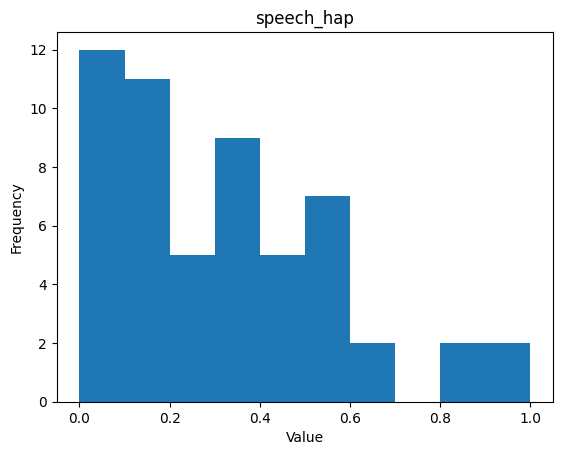

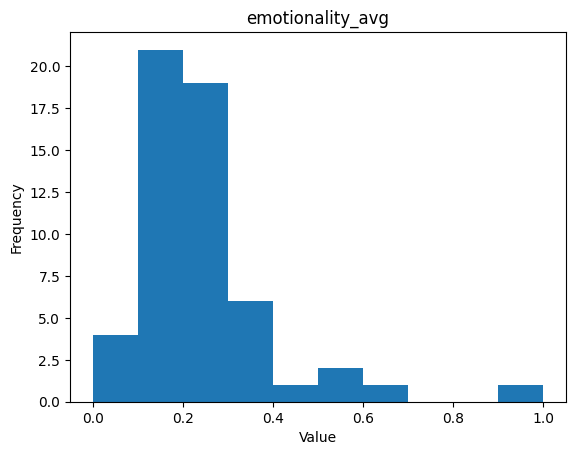

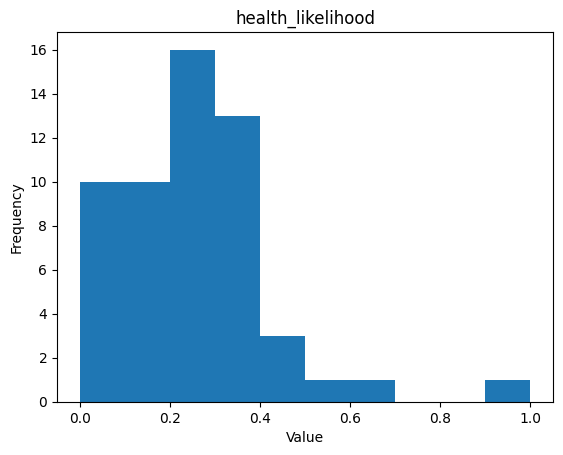

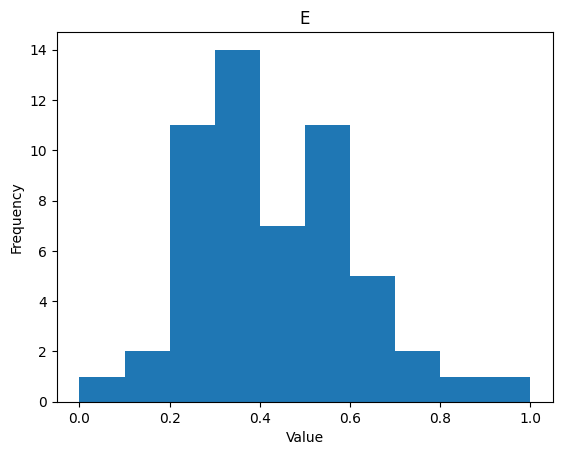

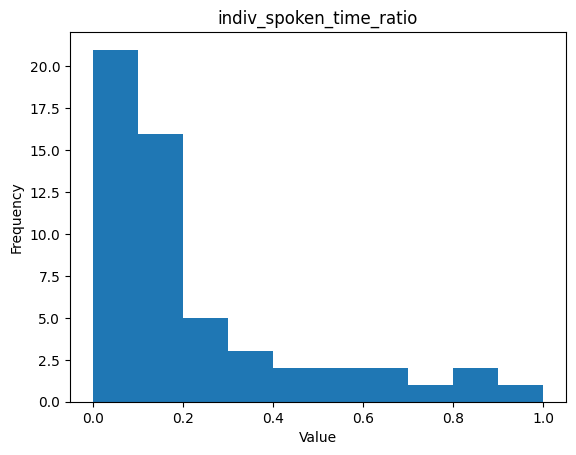

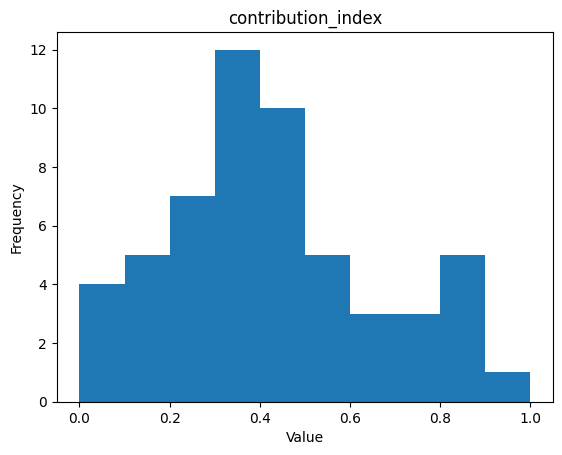

In [23]:
# Histograms of explanatory variables
for column in df.columns:
  if column!='mark':
    # Plot histogram
    plt.hist(df[column], bins=10, range=(0, 1))
    plt.title(column)  # Set column name as the title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()  # Show the histogram


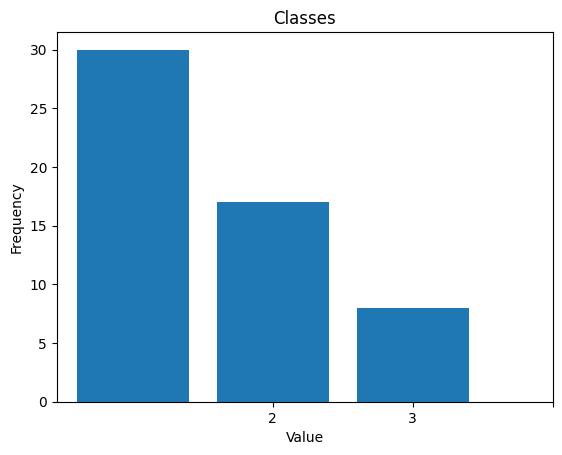

In [24]:
# Histograms of the objective variable: 

# Count the frequency of values in the 'theory' column
value_counts = df['mark'].value_counts()

# Plot bar chart
plt.bar(value_counts.index, value_counts.values)
plt.title('Classes')  # Set column name as the title
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.xticks([1, 2, 3])  # Set the x-ticks to match the values

plt.show()  # Show the bar chart

### Search and Return the best Model Hyperparameters

In [25]:
# Call the function and store the returned dictionary
result_dict = evaluate_random_forest_hyper_parameters(df, cv=5)

Best Model:
Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Mean Accuracy: 0.7455
Mean Cross-Validation Accuracy: 0.7273


### Feature Importance

Cross-Validation Scores: [0.54545455 0.81818182 0.81818182 0.72727273 0.72727273]
Mean Accuracy: 0.7272727272727273


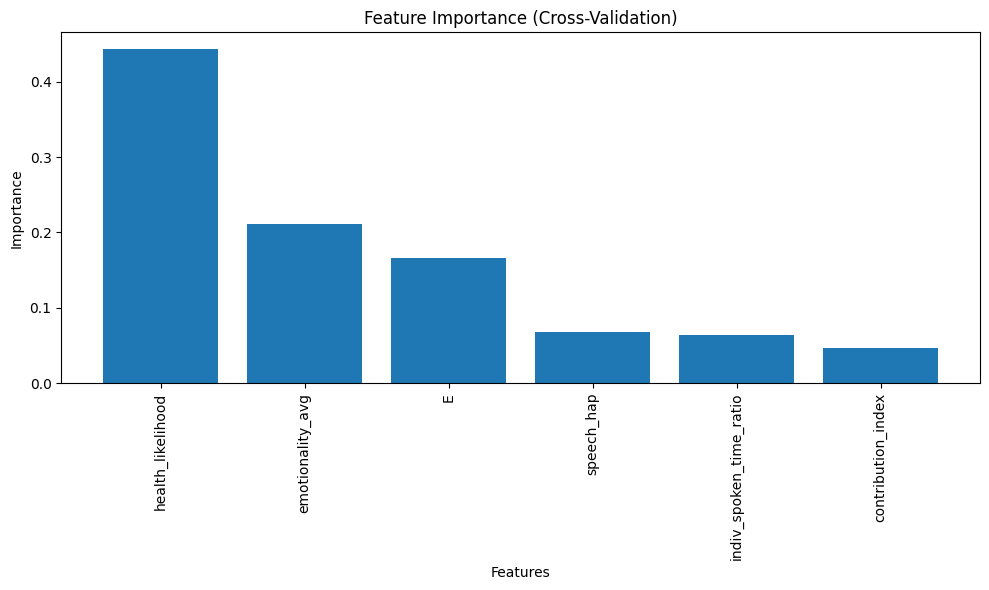

In [44]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Access the best model from the result_dict
best_model = result_dict['Best Model']

# Retrain the model using the entire dataset
best_model.fit(X, y)

# Perform cross-validation to evaluate model performance
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Analyze feature importance
feature_importances = best_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = df.columns[sorted_indices]  # Use the column names of your DataFrame

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Cross-Validation)')
plt.tight_layout()
plt.show()


### Confusion Matrix

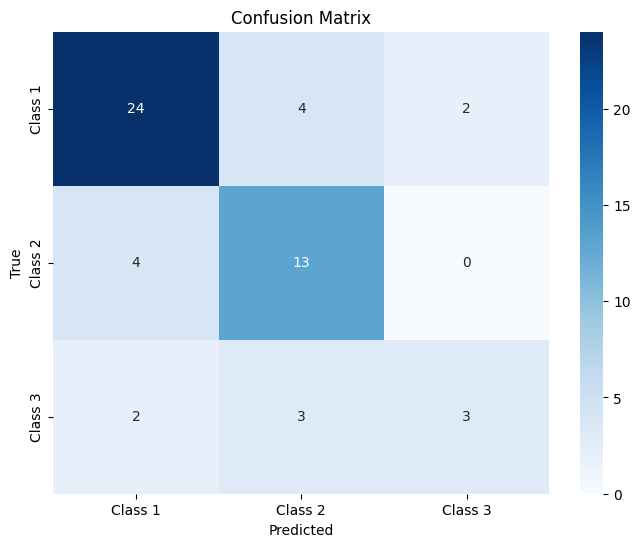

In [38]:
# Perform cross-validation predictions
skf = StratifiedKFold(n_splits=5)
y_pred_cv = np.zeros_like(y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_model.fit(X_train, y_train)
    y_pred_cv[test_index] = best_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred_cv)

# Define class labels
class_labels = ['Class 1', 'Class 2', 'Class 3']  # Replace with your actual class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Curve ROC

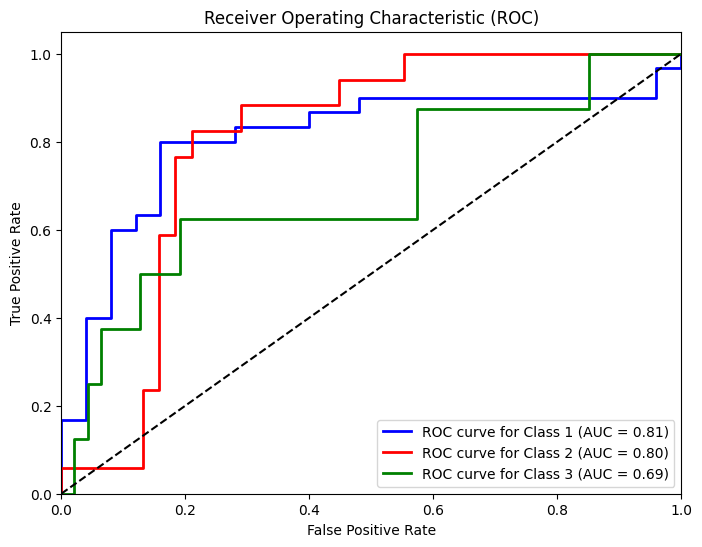

In [43]:
# Perform cross-validation predictions
skf = StratifiedKFold(n_splits=5)
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]
y_prob_cv = np.zeros((len(y), len(np.unique(y))))

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_model.fit(X_train, y_train)
    y_prob_cv[test_index] = best_model.predict_proba(X_test)

# Compute ROC curve and ROC AUC score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob_cv[:, i])
    roc_auc[i] = roc_auc_score(y_bin[:, i], y_prob_cv[:, i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_prob_cv.ravel())
roc_auc["micro"] = roc_auc_score(y_bin, y_prob_cv, average="micro")

# Define class labels
class_labels = ['Class 1', 'Class 2', 'Class 3']  # Replace with your actual class labels

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = itertools.cycle(['blue', 'red', 'green', 'purple', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
